In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES']='1'

In [2]:
import torch
import numpy as np
import cvxpy as cp
from osmm import OSMM

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

In [3]:
CPU = torch.device('cpu')
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    device = torch.device('cuda')
else:
    torch.set_default_tensor_type(torch.FloatTensor)
    device = CPU
print("device =", device)

device = cpu


## generate data

In [4]:
n_product = 500
n = n_product + 1
N = 10000
n_w = 2 * n_product

In [5]:
np.random.seed(0)
prod_linear = np.random.uniform(low=0.2, high=0.9, size=(n_product))
prod_linear_2 = 0.5 * prod_linear
prod_change_pnts = np.random.uniform(low=0.01, high=0.03, size=(n_product))
prod_amount_bounds = 5 * prod_change_pnts
prod_linear_torch = torch.tensor(prod_linear, dtype=torch.float)
prod_linear_2_torch = torch.tensor(prod_linear_2, dtype=torch.float)
prod_change_pnts_torch = torch.tensor(prod_change_pnts, dtype=torch.float)

In [6]:
cost_bound = 1.0
eta = 0.9

mean_return1 = .2
sigma_idyo = .05
sigma_fact = .3
NFACT = 5

factors_1 = np.random.randn(n_w, NFACT)
Sigma1 = 0.1 * factors_1.dot(factors_1.T)
mu1 = np.random.uniform(low=-mean_return1, high=0, size=(n_w))

In [7]:
def generate_random_data():
    # draw batch returns
    def draw_batch_returns(N_DRAWS):
        result = np.vstack([
            np.exp(np.random.multivariate_normal(mu1, Sigma1, size=int(N_DRAWS))),
        ])
        np.random.shuffle(result)
        return result

    learning_sample = draw_batch_returns(N)
    return learning_sample.T

In [8]:
W = generate_random_data()
W_validation = generate_random_data()

## define g and f

In [9]:
q_var = cp.Variable(n, nonneg=True)
production_cost = prod_linear.T @ q_var[0:n_product] + prod_linear_2.T @ cp.pos(q_var[0:n_product] - prod_change_pnts)
constrs = [production_cost <= cost_bound, q_var[0:n - 1] <= prod_amount_bounds, q_var[n - 1] >= 1e-10]

In [10]:
def my_f_torch(q_torch, W_torch):
    _, batch_size = W_torch.shape
    d_torch = W_torch[0:n_w // 2, :]
    p_torch = W_torch[n_w // 2:n_w, :]
    phi = torch.matmul(prod_linear_torch.T, q_torch[0:n_product]) + torch.matmul(prod_linear_2_torch.T, torch.relu(q_torch[0:n_product] - prod_change_pnts_torch))
    profits = torch.sum(p_torch * torch.min(d_torch, q_torch[0:n_product, None]), axis=0) - phi
    objf = q_torch[n - 1] * torch.logsumexp(-profits / q_torch[n - 1] - np.log(batch_size) - np.log(1 - eta), 0)
    return objf

## consturct osmm object

In [11]:
osmm_prob = OSMM()
osmm_prob.f_torch.function = my_f_torch
osmm_prob.f_torch.W = W
osmm_prob.f_torch.W_validate = W_validation
osmm_prob.g_cvxpy.variable = q_var
osmm_prob.g_cvxpy.objective = 0
osmm_prob.g_cvxpy.constraints = constrs

## solve

In [12]:
init_val = np.ones(n) * 0.001
osmm_prob.solve(init_val, verbose=True, 
#                 use_termination_criteria=False
               )

iter = 10, objf = -2.276e+00, lower bound = -2.303e+00, RMS residual = 3.187e-02, sampling acc = 2.292e-03, ||G||_F = 2.055e+01
iter = 20, objf = -2.283e+00, lower bound = -2.295e+00, RMS residual = 2.418e-02, sampling acc = 4.888e-04, ||G||_F = 1.932e+02
iter = 30, objf = -2.284e+00, lower bound = -2.291e+00, RMS residual = 2.020e-02, sampling acc = 1.227e-03, ||G||_F = 4.382e+02
iter = 40, objf = -2.285e+00, lower bound = -2.286e+00, RMS residual = 1.895e-02, sampling acc = 1.245e-03, ||G||_F = 1.437e+03
      Terminated. Num iterations = 40, objf = -2.285e+00, lower bound = -2.286e+00, RMS residual = 1.895e-02, sampling acc = 1.245e-03.
      Time elapsed (secs): 10.660782.



-2.284597635269165

## plot result

In [13]:
total_iters = osmm_prob.method_results["total_iters"]
iters = np.array([i for i in range(0, total_iters + 1)])

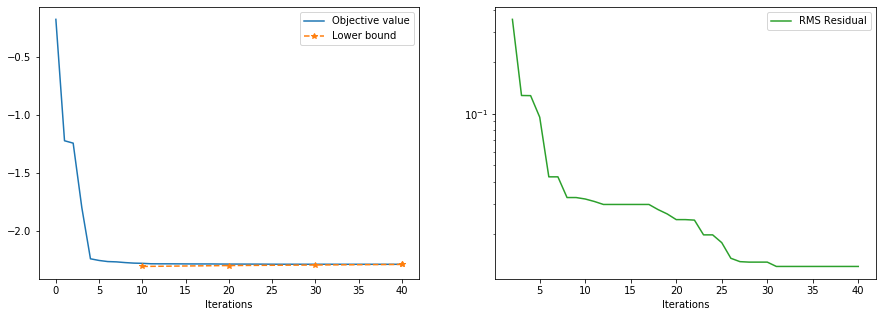

In [14]:
fig = plt.figure(tight_layout=False, figsize=(15, 5))
gs = gridspec.GridSpec(1, 2)

plot1 = fig.add_subplot(gs[0, 0])
plot1.plot(iters, osmm_prob.method_results["objf_iters"][0:total_iters + 1], label="Objective value")
lower_bound_idxs = [i for i in range(0, total_iters + 1, 10)] + [total_iters]
plot1.plot(iters[lower_bound_idxs], osmm_prob.method_results["lower_bound_iters"][lower_bound_idxs], 
           '--*', label="Lower bound")

plot1.set_xlabel("Iterations")
plot1.legend()

#=========================================================================================================
plot2 = fig.add_subplot(gs[0, 1])
start_idx = 2
rms_res_running_min = np.array(osmm_prob.method_results["rms_res_iters"][0:total_iters + 1])
for i in range(start_idx, total_iters + 1):
    rms_res_running_min[i] = np.min(osmm_prob.method_results["rms_res_iters"][start_idx:i + 1])

plot2.plot(iters[start_idx::], rms_res_running_min[start_idx::], label="RMS Residual", color='#2ca02c')

plot2.set_xlabel("Iterations")
plot2.set_yscale("log")
plot2.legend()

/Users/xinyueshen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


a 0.07498020035475599
cost =  1.0000000000285478


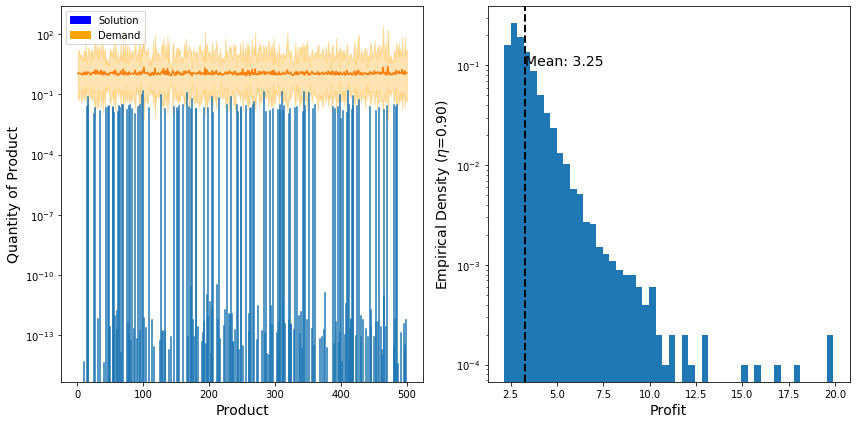

In [15]:
linewidth = 2
fontsize = 14

fig = plt.figure(tight_layout=True, figsize=(12, 6))
gs = gridspec.GridSpec(1, 2)

a = fig.add_subplot(gs[0, 0])  # gs[0, :]
a.stem([i for i in range(1, n - 1)], osmm_prob.method_results["soln"][0:n - 2], markerfmt=" ", label="Solution")
print("a", osmm_prob.method_results["soln"][-1])
a.set_xlabel("Product", fontsize=fontsize)
a.set_ylabel("Quantity of Product", fontsize=fontsize)
a.set_yscale("log")

labels = []
labels.append((mpatches.Patch(color="blue"), "Solution"))
labels.append((mpatches.Patch(color="orange"), "Demand"))
a.plot([i for i in range(1, n_product + 1)], np.mean(W[0:n_w // 2, :], axis=1))
a.fill_between([i for i in range(1, n_product + 1)], np.min(W[0:n_product, :], axis=1),
                np.max(W[0:n_product, :], axis=1), alpha=0.3, color='orange')
plt.legend(*zip(*labels), loc=2)

###################################################################
b = fig.add_subplot(gs[0, 1])
D = W[0:n_w // 2, :]
P = W[n_w // 2:n_w, :]
cost = osmm_prob.method_results["soln"][0:n_product].T.dot(prod_linear) + np.maximum(osmm_prob.method_results["soln"][0:n_product] - prod_change_pnts, 0).T.dot(prod_linear_2)
profits = np.sum(P.T * (np.minimum(D.T, osmm_prob.method_results["soln"][0:n_product])), axis=1) - cost
weights = np.ones_like(profits) / len(profits)
b.hist(profits, weights=weights, bins=50)
b.axvline(profits.mean(), color='k', linestyle='dashed', linewidth=linewidth)
b.text(profits.mean(), 0.1, 'Mean: {:.2f}'.format(profits.mean()), fontsize=fontsize)
b.set_xlabel("Profit", fontsize=fontsize)
b.set_ylabel(r"Empirical Density ($\eta$={:.2f})".format(eta), fontsize=fontsize)
b.set_yscale("log")
print("cost = ", cost)